`Course Instructor`: **John Chiasson**

`Author (TA)`: **Ruthvik Vaila**

# Notes:
* In this notebook we shall load a large `NumPy` array directly into RAM to train a model.
* While the model is training keep an eye on the time taken and RAM usage of your machine.
* Tested on `Python 3.7.5` with `Tensorflow 1.15.0` and `Keras 2.2.4`. 
* Tested on `Python 2.7.17` with `Tensorflow 1.15.3` and `Keras 2.2.4`. 

# Imports

In [1]:
import sys, os
sys.version

'3.7.5 (default, Nov  7 2019, 10:50:52) \n[GCC 8.3.0]'

In [2]:
from tensorflow.compat.v1 import InteractiveSession
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"]="0" #setting it to -1 hides the GPU.
#tf.compat.v1.enable_eager_execution()
from tensorflow.python.client import device_lib
import numpy as np
import IPython
import sys, pickle, os, gzip
import h5py, time, inspect
import IPython.display as display
from keras.utils import to_categorical
import keras, warnings
import matplotlib.pyplot as plt
import feature_reconstruction as fs
warnings.filterwarnings(action='once')
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
session = InteractiveSession(config=config)
# this make sure thaat if using a gpu total gpu memory is not gobbled
# up by tensorflow and allows growth as required
##https://github.com/tensorflow/tensorflow/issues/24828

Using TensorFlow backend.
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-1i_ztl0u because the default path (/home/visionteam/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5799149511237715972,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 4480088046321760802
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14114210079001750485
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6896638362
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1578950884593285108
 physical_device_desc: "device: 0, name: GeForce RTX 2080 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"]

In [4]:
print('TF version:{}, Keras version:{}'.format(tf.__version__, keras.__version__))

TF version:1.15.0, Keras version:2.2.4


# Load the data
* There are `60000` images in the training set and each image needs to be of size `(28, 28, 1)` for `Keras`. The extra dimension in `(28, 28, 1)` indicates number of channels. In this case we have `1` channel because it's a gray scale image. In datasets like `CIFAR-10`, `CIFAR-100`, and `ImageNet` images have `3` channels `(RGB)`. 

In [5]:
filename = 'data/mnist.pkl.gz'
filehandle = gzip.open(filename, 'rb')
train_data, val_data, test_data = pickle.load(filehandle, encoding='latin1')
#train_data, val_data, test_data = pickle.load(filehandle)
filehandle.close()
train_x, train_y = train_data
print('Train data shape:{} and labels shape:{}'.format(train_x.shape, train_y.shape))
val_x, val_y = val_data
print('Valid data shape:{} and labels shape:{}'.format(val_x.shape, val_y.shape))
## combine train and validation data, classifier_class can split it inside 
train_x = np.concatenate([train_x, val_x], axis=0)
train_y = np.concatenate([train_y, val_y], axis=0)
print('Train data shape:{}'.format(train_x.shape))
train_x = train_x.reshape(train_x.shape[0], 28, 28, 1)
print('Train data shape after reshaping:{}'.format(train_x.shape))
print('Train labels shape:{}'.format(train_y.shape))
test_x, test_y = test_data
print('Test data shape:{}'.format(test_x.shape))
test_x = test_x.reshape(test_x.shape[0], 28, 28, 1)
print('Test data shape after reshaping:{}'.format(test_x.shape))
print('Test labels shape:{}'.format(test_y.shape))


Train data shape:(50000, 784) and labels shape:(50000,)
Valid data shape:(10000, 784) and labels shape:(10000,)
Train data shape:(60000, 784)
Train data shape after reshaping:(60000, 28, 28, 1)
Train labels shape:(60000,)
Test data shape:(10000, 784)
Test data shape after reshaping:(10000, 28, 28, 1)
Test labels shape:(10000,)


## One hot vectorize labels

In [6]:
train_y = to_categorical(train_y)
print('Train labels shape:{}'.format(train_y.shape))

test_y = to_categorical(test_y)
print('Test labels shape:{}'.format(test_y.shape))

Train labels shape:(60000, 10)
Test labels shape:(10000, 10)


## Visualize the dataset.

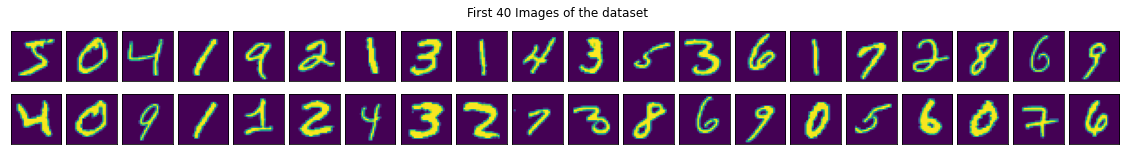

In [7]:
fig, axes = plt.subplots(2, 20, figsize=(20,4), subplot_kw={'xticks': [], 'yticks': []})
fig.subplots_adjust(left=0.12, bottom=0.5, right=0.89, top=0.9, wspace=0.1, hspace=0.21)
axes = axes.flatten()
for i in range(len(axes)):
    axes[i].imshow(train_x[i,:,:,0])
plt.suptitle('First 40 Images of the dataset')
plt.show()

# Setup a small CNN model using `tf.keras.Sequential` 
* A simple convolutional neural network with the structure
* `32c32p64c64p->200->10`
* `Adam optimizer` and `Cross Entropy Loss` with a learning rate ($\alpha$) set to `0.005`.

In [8]:
eta = 0.0005
val_frac = 0.1 #Fraction of training data to be used for validation 
# FIRST CONVOLUTION LAYER
nC1_kernels = 32 ##number of kernels in the first convolutional layer
C1_kernel_shape = (5, 5) ## size of the kernel in the first convolutional layer (5,5)
C1_stride = 1 ## stride of the convolution
C1_activation = 'relu' ## activation function of the C1 neurons
P1_kernel_shape = (2, 2) ## Size of the pooling window (2,2) 
P1_stride = 2 ## stride of the pooling window

# SECOND CONVOLUTION LAYER
nC2_kernels = 64
C2_kernel_shape = (3, 3)
C2_stride = 1
C2_activation = 'relu'
P2_kernel_shape = (2, 2)
P2_stride = 2

# FULLY CONNECTED LAYER
n_dense = 200
dense_activation = 'relu'

# FINAL LAYER
last_activation = 'softmax'
cost_function = 'categorical_crossentropy'
n_out = 10
optimizer = 'adam' #'sgd'

In [9]:
model = tf.keras.Sequential()

#FIRST CONVOLUTION LAYER
model.add(tf.keras.layers.Conv2D(nC1_kernels, C1_kernel_shape, C1_stride, activation=C1_activation,
                                input_shape=(28, 28, 1)))
model.add(tf.keras.layers.MaxPooling2D(P1_kernel_shape, P1_stride))

#SECOND CONVOLUTION LAYER
model.add(tf.keras.layers.Conv2D(nC2_kernels, C2_kernel_shape, C2_stride, activation=C2_activation))
model.add(tf.keras.layers.MaxPooling2D(P2_kernel_shape, P2_stride))
model.add(tf.keras.layers.Flatten())

#FULLY CONNECTED LAYERS
model.add(tf.keras.layers.Dense(n_dense, activation=dense_activation))
model.add(tf.keras.layers.Dense(n_out, activation=last_activation))

#COMPILE THE MODEL
if(optimizer=='adam'):
    optim = tf.keras.optimizers.Adam(lr=eta)
else:
    optim = tf.keras.optimizers.SGD(lr=eta)
    
model.compile(optimizer=optim, loss=cost_function, metrics=['accuracy'])
print(model.summary())

#CALLBACK TO KERAS TO SAVE BEST MODEL WEIGHTS
best_weights="cnn_weights_best.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(best_weights, monitor='val_acc', verbose=1, save_best_only=True,
                                                mode='max')


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 200)               320200    
_________________________________________

/home/visionteam/python37_env/lib/python3.7/site-packages/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()
/home/visionteam/python37_env/lib/python3.7/site-packages/tensorflow_core/python/training/tracking/data_structures.py:669: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(wrapped_dict, collections.Mapping):


## Train the CNN

In [10]:
mini_batch_size = 32
history = model.fit(train_x,train_y, epochs=3, batch_size=mini_batch_size, callbacks=[checkpoint],
                   validation_split=0.1)

/home/visionteam/python37_env/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:339: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(values, collections.Sequence):
/home/visionteam/python37_env/lib/python3.7/site-packages/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


Train on 54000 samples, validate on 6000 samples
Epoch 1/3
53408/54000 [============================>.] - ETA: 0s - loss: 0.1556 - acc: 0.9544- ETA
Epoch 00001: val_acc improved from -inf to 0.97667, saving model to cnn_weights_best.hdf5
54000/54000 [==============================] - 5s 94us/sample - loss: 0.1546 - acc: 0.9547 - val_loss: 0.0736 - val_acc: 0.9767
Epoch 2/3
53408/54000 [============================>.] - ETA: 0s - loss: 0.0478 - acc: 0.9852
Epoch 00002: val_acc improved from 0.97667 to 0.98983, saving model to cnn_weights_best.hdf5
54000/54000 [==============================] - 4s 70us/sample - loss: 0.0477 - acc: 0.9853 - val_loss: 0.0362 - val_acc: 0.9898
Epoch 3/3
53664/54000 [============================>.] - ETA: 0s - loss: 0.0326 - acc: 0.9900
Epoch 00003: val_acc improved from 0.98983 to 0.99017, saving model to cnn_weights_best.hdf5
54000/54000 [==============================] - 4s 70us/sample - loss: 0.0326 - acc: 0.9900 - val_loss: 0.0333 - val_acc: 0.9902


# Test the model at the end

In [11]:
model.evaluate(test_x, test_y, batch_size=len(test_x))

10000/10000 [==============================] - 1s 64us/sample - loss: 0.0253 - acc: 0.9905


[0.025286206975579262, 0.9905]

# Test at the best validation accuracy

In [12]:
model.load_weights(best_weights)
model.compile(optimizer=optim, loss=cost_function, metrics=['accuracy'])
model.evaluate(test_x, test_y, batch_size=len(test_x))

10000/10000 [==============================] - 0s 7us/sample - loss: 0.0253 - acc: 0.9905


[0.025286206975579262, 0.9905]

# Get the weights

In [13]:
#Conv1 
conv1_kernels = model.layers[0].get_weights()[0]
print('Shape of Conv1 kernels:{}'.format(conv1_kernels.shape))
conv1_biases = model.layers[0].get_weights()[1]
print('Shape of Conv1 biases:{}\n'.format(conv1_biases.shape))

#Conv2 
# it's model.layers[2] instead of model.layers[1] because model.layers[1] is a pooling layer
# and pooling layers have neither biases or weights

conv2_kernels = model.layers[2].get_weights()[0]
print('Shape of Conv2 kernels:{}'.format(conv2_kernels.shape))
conv2_biases = model.layers[2].get_weights()[1]
print('Shape of Conv2 biases:{}\n'.format(conv2_biases.shape))

#First fully connected layer
# it's  model.layers[5] because model.layers[3] is a pooling layer and model.layers[4] is a
# flattening "layer"

fcn1_weights = model.layers[5].get_weights()[0]
print('Shape of first fully connected layer weights:{}'.format(fcn1_weights.shape))
fcn1_biases = model.layers[5].get_weights()[1]
print('Shape of first fully connected layer biases:{}\n'.format(fcn1_biases.shape))

fcn2_weights = model.layers[6].get_weights()[0]
print('Shape of second fully connected layer weights:{}'.format(fcn2_weights.shape))
fcn2_biases = model.layers[6].get_weights()[1]
print('Shape of second fully connected layer biases:{}\n'.format(fcn2_biases.shape))

Shape of Conv1 kernels:(5, 5, 1, 32)
Shape of Conv1 biases:(32,)

Shape of Conv2 kernels:(3, 3, 32, 64)
Shape of Conv2 biases:(64,)

Shape of first fully connected layer weights:(1600, 200)
Shape of first fully connected layer biases:(200,)

Shape of second fully connected layer weights:(200, 10)
Shape of second fully connected layer biases:(10,)



# Visualize `Conv1` weights
* Try and fix this picture.

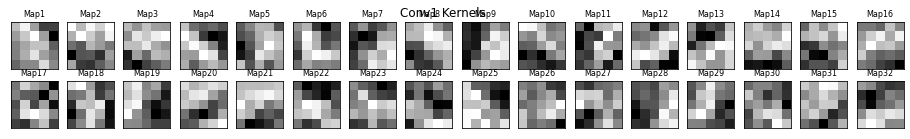

In [14]:
fig, axes = plt.subplots(2, 16, figsize=(16,2), subplot_kw={'xticks': [], 'yticks': []})
#fig.subplots_adjust(left=0.12, bottom=0.5, right=0.89, top=0.9, wspace=0.1, hspace=0.21)
axes = axes.flatten()
for i in range(len(axes)):
    axes[i].imshow(conv1_kernels[:,:,0,i], cmap='gray')
    axes[i].set_title('Map'+str(i+1), fontsize=8)
plt.suptitle('Conv1 Kernels')
plt.show()

# Visualize reconstructed `Conv2` weights 
* Reconstructed features don't really show us anything.

In [15]:
conv1_kernels = conv1_kernels - conv1_kernels.min()
conv1_kernels /= conv1_kernels.max()
print(conv1_kernels.min(), conv1_kernels.max())

conv2_kernels = conv2_kernels - conv2_kernels.min()
conv2_kernels /= conv2_kernels.max()
print(conv2_kernels.min(), conv2_kernels.max())

0.0 1.0
0.0 1.0


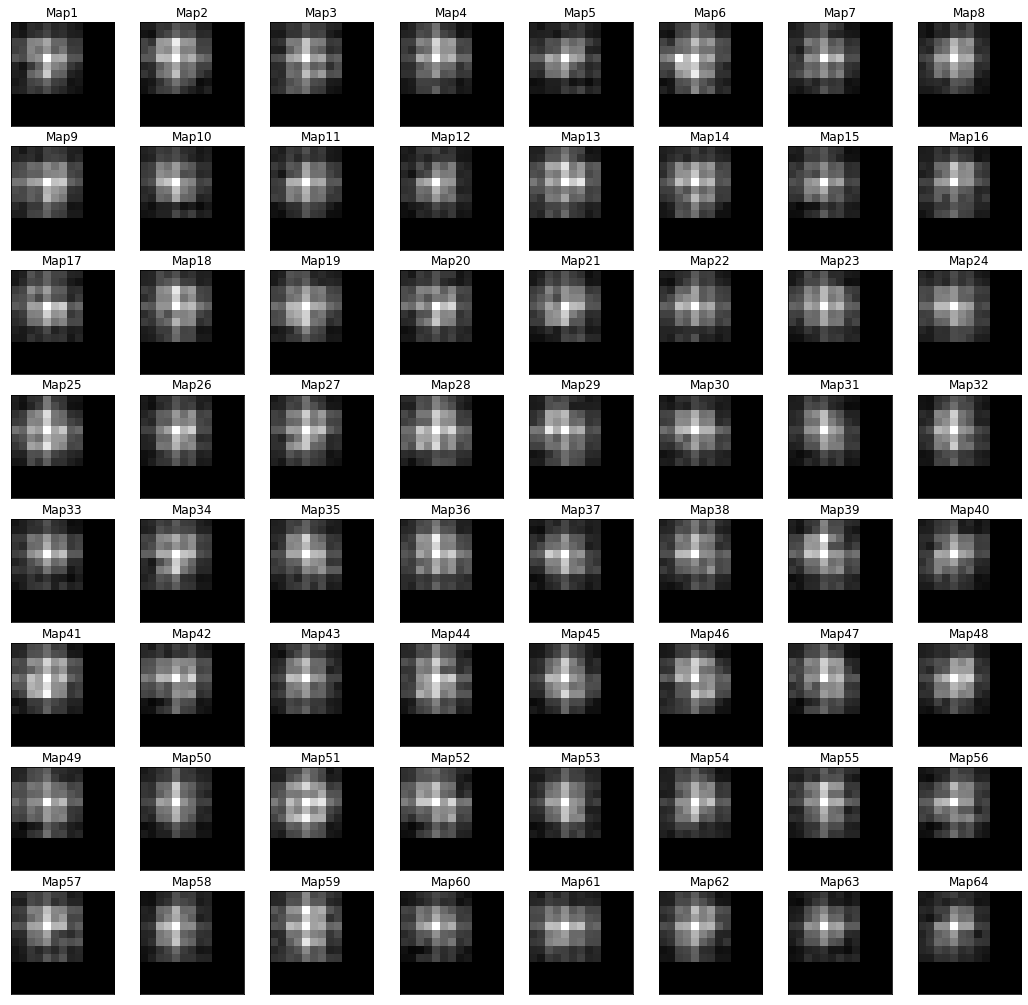

In [16]:
layer_num = [2,3,4]
filter_sizes = [5, 2, 3] ##[list of synapses from  first to last layers]
filter_strides = [1,2,1]
nof_filters = [32, 32, 64] ##[list of number of filters from first to last layers]
types = ['conv','pool','conv']
currLayer= 4
layer_weights=[[conv1_kernels],[conv2_kernels]]
fig, final_features = fs.feature_visualization(layer_weights,plotx=8,ploty=8,layer_num=layer_num,\
                          filter_sizes=filter_sizes,filter_strides=filter_strides,nof_filters=nof_filters,\
                          types=types,currLayer=currLayer,show=True, figsize=(15,15))
fig.subplots_adjust(left=0.03, bottom=0.0, right=0.99, top=0.9, wspace=0.0, hspace=0.2)

# Restart the notebook to free up the `GPU` and `RAM`.

In [18]:
IPython.Application.instance().kernel.do_shutdown(True) #automatically restarts kernel

{'restart': True, 'status': 'ok'}